In [ ]:
import numpy as np
import os
import kaldi_io
import kaldiio
import torch
from tqdm import tqdm
from scipy.stats import norm
import statistics
from scipy import stats
import pandas as pd
import seaborn as sns
import random

# import ot
import umap
import soundfile as sf
# from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
# from sklearn.manifold import t_sne
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import pyplot as plt

from Misc.OptimalTransport.optimal_transport import compute_optimal_transport, OptimalTransport
from Process_Data.audio_processing import read_WaveInt

# plt.rc('font', family='Times New Roman', weight='semibold')
# import seaborn as sns
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# palette = sns.color_palette("bright", 10)

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [ ]:
from Define_Model.ResNet import ThinResNet
from Define_Model.Loss.SoftmaxLoss import AdditiveMarginLinear

data_dir = '/home/yangwenhao/project/SpeakerVerification-pytorch'
lstm_dir = '/home/yangwenhao/project/lstm_speaker_verification/data'
file_loader = read_WaveInt

In [ ]:
epoch = 13
tdnn_ckp_dir = 'Data/checkpoint/ThinResNet34/cnceleb/hdf5_baseline/arcsoft_sgd_rop/Mean_batch256_cbam_downk3_avg5_SAP2_em256_dp01_alpha0_none1_wd5e4_varesmix2_dist/baseline_int_original/123456//checkpoint_%d.pth' % (epoch)
resnet_model = torch.load(data_dir + "/" + tdnn_ckp_dir)

model = ThinResNet(resnet_size=34, num_classes=797, embedding_size=256,
                   input_dim=80, feat_dim=80, filter="fbank",
                   alpha=0., input_norm='Mean', encoder_type='SAP2', block_type='cbam',
                   downsample='k3',
                   kernel_size=[5,5], stride=[2,1], channels=[16, 32, 64, 128],
                   dropout_p=0.1, avg_size=5,
                  )
model.classifier = AdditiveMarginLinear(feat_dim=256, num_classes=797)
model.load_state_dict(resnet_model['state_dict'])

In [30]:
def feature_encode(model, feat, layer=1):
    with torch.no_grad():
        x = model.input_mask(feat)
        if layer == 0:
            return x

        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        if layer == 1:
            return x

        if model.maxpool != None:
            x = model.maxpool(x)

        group1 = model.layer1(x)
        if layer == 2:
            return x

        group2 = model.layer2(group1)
        if layer == 3:
            return x

        group3 = model.layer3(group2)
        if layer == 4:
            return x

        group4 = model.layer4(group3)
        if layer == 5:
            return x

        if model.dropout_p > 0:
            group4 = model.dropout(group4)

        if model.avgpool != None:
            x = model.avgpool(group4)
        if layer == 6:
            return x

        if model.encoder != None:
            x = model.encoder(x)

        if layer == 7:
            return x

        x = x.view(x.size(0), -1)

        x = model.fc1(x)

        return x

In [6]:
classifier_Center = resnet_model['state_dict']['classifier.W'].cpu()
print(classifier_Center.shape)

classifier_Center[:,1].shape

torch.Size([256, 797])


torch.Size([256])

In [7]:
cnc_dir = 'cnceleb/dev/wav.scp'
spk_domain_dict = {}
domains = set([])
uid2upath = {}
with open(os.path.join(lstm_dir, cnc_dir), 'r') as f:
    
    for l in f.readlines():
        uid = l.split()[0]
        uid2upath[uid] = l.split()[4]
        
        sid, domain,_,_ = uid.split('-')
        domains.add(domain)
        if sid in spk_domain_dict:
            spk_domain_dict[sid].add(domain)
        else:
            spk_domain_dict[sid] = set([domain])

In [8]:
cnc_dir = 'cnceleb/klfb/dev_fb40'
spk2uid_dict = {}
with open(os.path.join(lstm_dir, cnc_dir, 'spk2utt'), 'r') as f:
    for l in f.readlines():
        spk2uid_dict[l.split()[0]] = l.split()[1:]

In [51]:
multi_spks = []
for spk in spk_domain_dict:
    if len(spk_domain_dict[spk]) > 2:
        multi_spks.append(spk)

target_spks = []
target_doms = set([])

for i, spk in enumerate(multi_spks):
    target_spks = [spk]
    target_doms = set(spk_domain_dict[spk]) 
    for other_spk in multi_spks[i+1:]:
        if len( target_doms | set(spk_domain_dict[other_spk]) ) > 6 or len( target_doms & set(spk_domain_dict[other_spk]) ) < 3:
            continue
        else:
            target_spks.append(other_spk)
            target_doms = target_doms | set(spk_domain_dict[other_spk])
            
        if len(target_spks) >= 4:
            break
            
    if len(target_spks) >= 4:
        break

print(target_doms)
# print(target_spks)
for t in target_spks:
    print(t, spk_domain_dict[t])

{'singing', 'entertainment', 'interview'}
id00004 {'entertainment', 'interview', 'singing'}
id00018 {'entertainment', 'interview', 'singing'}
id00056 {'entertainment', 'interview', 'singing'}
id00057 {'entertainment', 'interview', 'singing'}


In [ ]:
# spk_domain_dict['id00007']
# all_sids = ["id00038", "id00094","id00061", "id00070", 'id00096', 'id00100']
all_sids = target_spks
all_sid2idx = {s: i for i,s in enumerate(all_sids)}

In [ ]:
frame_lenght = 48000
for this_sid in all_sids:
    this_spks_dom2segs = {p:0 for p in spk_domain_dict[this_sid]}

    for uid in spk2uid_dict[this_sid]:
        feat = file_loader(uid2upath[uid])[0]
        
        g = uid.split('-')[1]
        this_spks_dom2segs[g] += int(len(feat)/frame_lenght)       
        
    print(this_sid, this_spks_dom2segs)

In [42]:
balanced_feats = []
for this_sid in all_sids:
    this_spks2feats = {g: [] for g in spk_domain_dict[this_sid]}
    
    for uid in spk2uid_dict[this_sid]:
        feats = file_loader(uid2upath[uid])[0]
#         print(len(feats))
        g = uid.split('-')[1]
        
        if len(feats) >= frame_lenght:
             for i in range(int(len(feats)/frame_lenght)):
                start = i*frame_lenght
                end =  i*frame_lenght+frame_lenght

                if i*frame_lenght+frame_lenght > len(feats):
                    end = len(feats)
                    start = end - frame_lenght

                this_feat = feats[start:end]
                this_feat = torch.tensor(this_feat.reshape([1, -1])).unsqueeze(0).unsqueeze(0)
                    
                this_spks2feats[g].append([uid+'-%d'%i, this_feat])
        
    for g in this_spks2feats:
#         print(this_sid, '{:>14s} '.format(g), len(this_spks2feats[g]))
        random.shuffle(this_spks2feats[g])
        this_spks2feats[g] = this_spks2feats[g][:30]
#         print(this_sid, '{:>14s} '.format(g), len(this_spks2feats[g]))
    
    this_spk_feats= []
    for g in this_spks2feats:
        this_spk_feats.extend(this_spks2feats[g])
    
    balanced_feats.extend(this_spk_feats)

In [43]:
model = model.cuda()
model.eval()

layer_features = {}
layers = [0, 1, 2, 3, 4, 5, 7, 8]
# layers = [0,]

for layer in layers:
    feat_maps = []
    fm_uids = []
    
    for uid, feat in balanced_feats:
        this_feat = feat.cuda()
        fm_uids.append(uid)
        feat_maps.append(feature_encode(model, this_feat, layer).squeeze().cpu().detach().numpy())

    feat_gid = [uid.split('-')[1] for uid in fm_uids]    
    feat_sid = [uid.split('-')[0] for uid in fm_uids]    
        
    np_feat_maps = np.array(feat_maps)
    
    layer_features[layer] = [np_feat_maps, feat_sid, feat_gid]

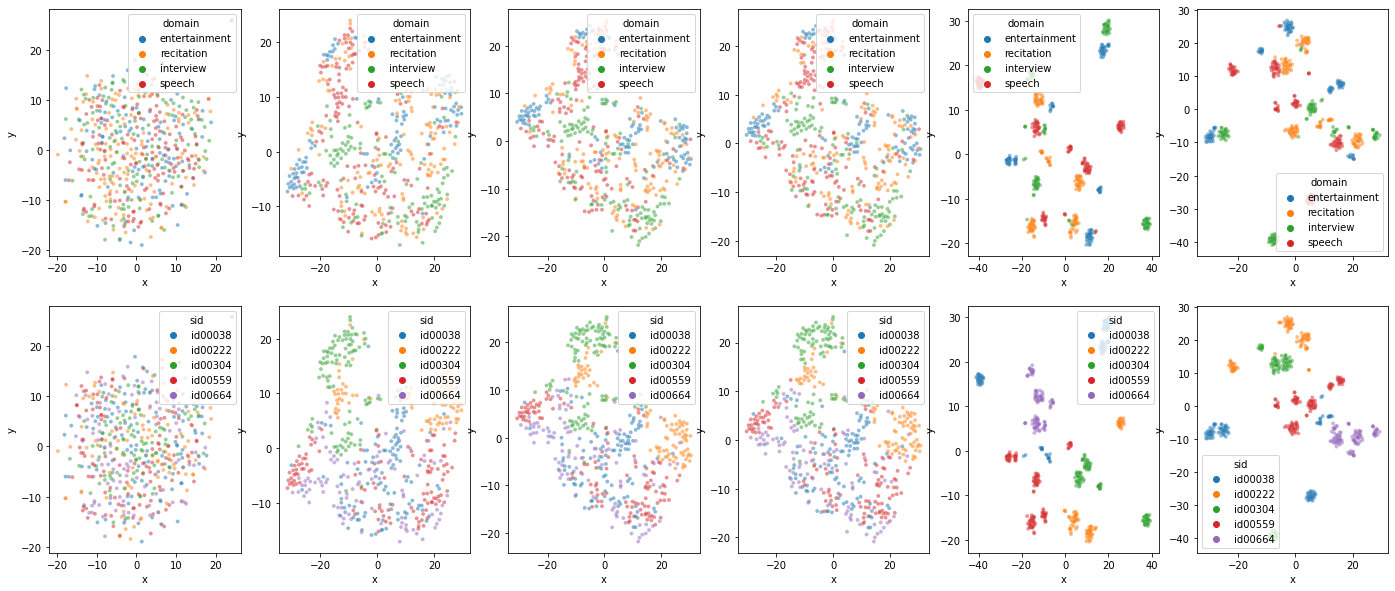

In [44]:
plt.figure(figsize=(24, 10))
layers = [0, 1, 3, 5, 7, 8]
pca_dim=128

for i,j in enumerate(layers):
    np_feat_maps, feat_sid, feat_gid = layer_features[j]
    
    feat_shape = np_feat_maps.shape
    np_feat_maps = np_feat_maps.reshape(feat_shape[0], feat_shape[1], -1)
    if len(np_feat_maps.shape) == 3:
        np_feat_maps = np.concatenate([np_feat_maps.mean(axis=2),np_feat_maps.std(axis=2)], axis=1) 
    
    if np_feat_maps.shape[-1] > pca_dim:
        feat = PCA(n_components=pca_dim).fit_transform(np_feat_maps)
    else:
        feat = np_feat_maps
    # embedded_feat = TSNE(n_components=2, init='pca').fit_transform(feat_pca)
    embedded_feat = TSNE(n_components=2, init='pca').fit_transform(feat)

    pd_emb_feat = pd.DataFrame(embedded_feat, columns=['x', 'y'])
    pd_emb_feat.insert(2, 'domain', feat_gid)
    pd_emb_feat.insert(3, 'sid',    feat_sid)
    
    plt.subplot(2,len(layers), i+1)
    sns.scatterplot(data=pd_emb_feat, x='x', y='y', hue='domain', s=15, alpha=0.5, linewidth=0.1)
    
    plt.subplot(2,len(layers),i+1+len(layers))
    sns.scatterplot(data=pd_emb_feat, x='x', y='y', hue='sid', s=15, alpha=0.5, linewidth=0.1)
    
plt.savefig('imgs/resnet/tsne_style_pca%d.png'%(pca_dim), bbox_inches='tight')

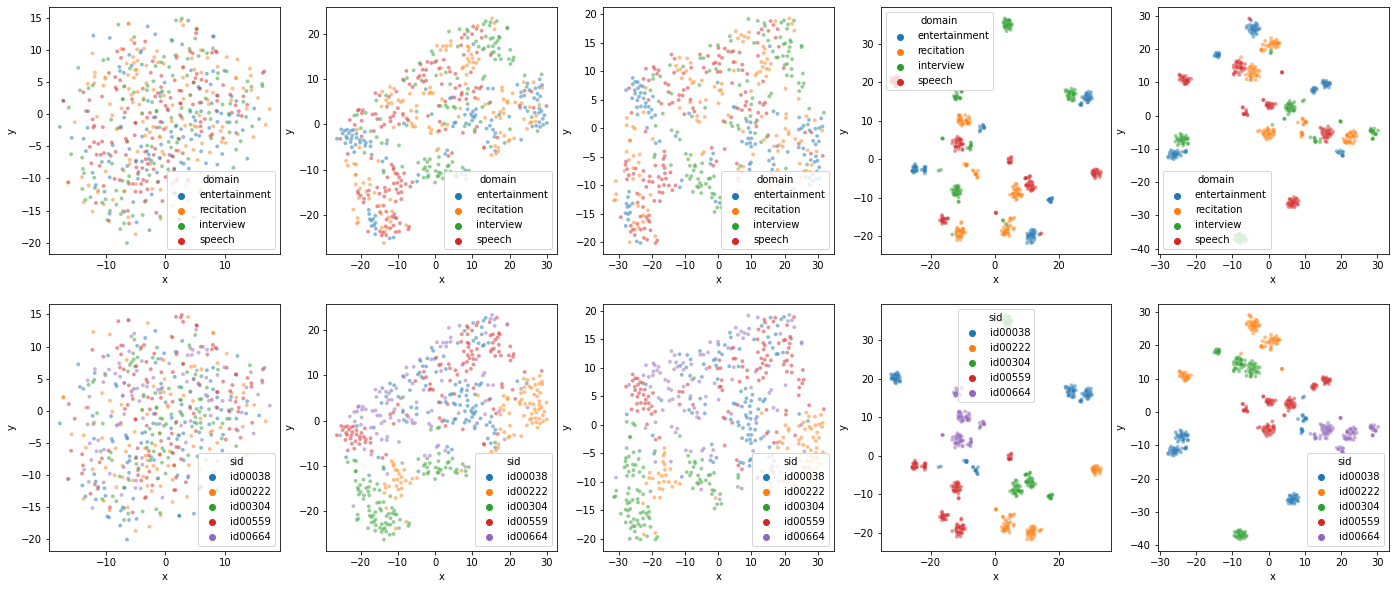

In [45]:
plt.figure(figsize=(24, 10))
layers = [0, 1, 5, 7, 8]
pca_dim=128

for i,j in enumerate(layers):
    np_feat_maps, feat_sid, feat_gid = layer_features[j]
    
    feat_shape = np_feat_maps.shape
    np_feat_maps = np_feat_maps.reshape(feat_shape[0], feat_shape[1], -1)
    if len(np_feat_maps.shape) == 3:
        np_feat_maps = np_feat_maps.mean(axis=2)
        
    if np_feat_maps.shape[-1] > pca_dim:
        feat = PCA(n_components=pca_dim).fit_transform(np_feat_maps)
    else:
        feat = np_feat_maps

    embedded_feat = TSNE(n_components=2, init='pca').fit_transform(feat)

    pd_emb_feat = pd.DataFrame(embedded_feat, columns=['x', 'y'])
    pd_emb_feat.insert(2, 'domain', feat_gid)
    pd_emb_feat.insert(3, 'sid',    feat_sid)
    
    plt.subplot(2,len(layers), i+1)
    sns.scatterplot(data=pd_emb_feat, x='x', y='y', hue='domain', s=15, alpha=0.5, linewidth=0.1)
    
    plt.subplot(2,len(layers),i+1+len(layers))
    sns.scatterplot(data=pd_emb_feat, x='x', y='y', hue='sid', s=15, alpha=0.5, linewidth=0.1)
    
plt.savefig('imgs/resnet/tsne_mean_pca%d.png'%(pca_dim), bbox_inches='tight')

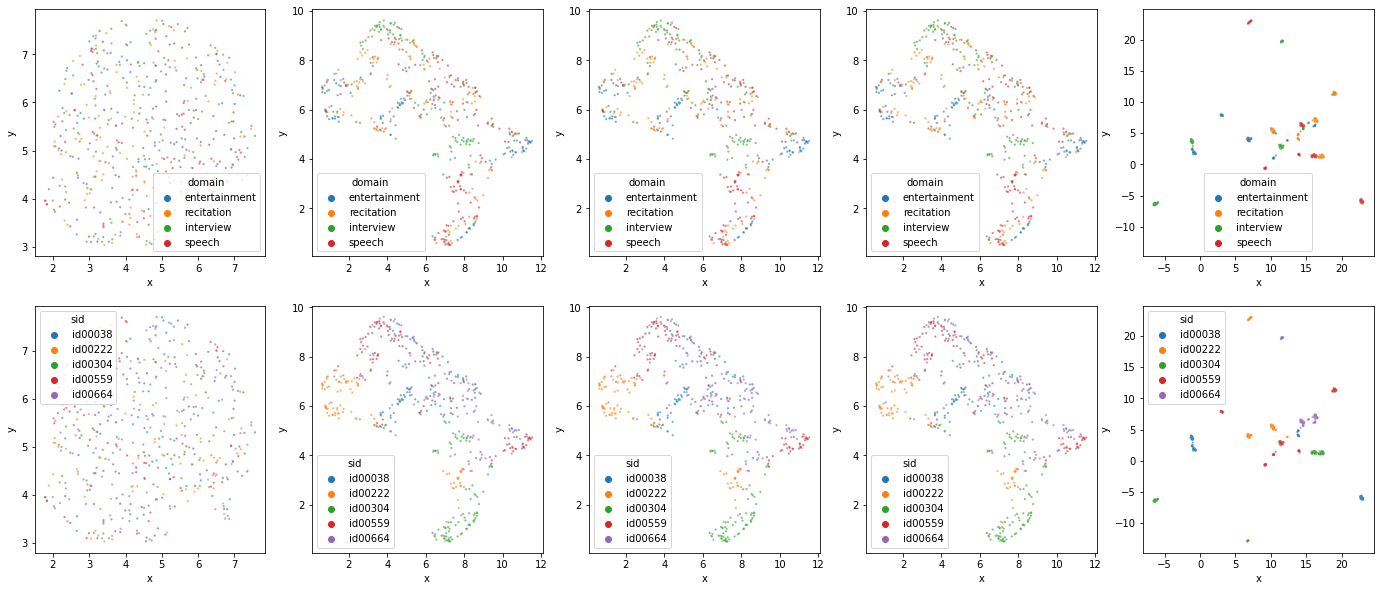

In [46]:
plt.figure(figsize=(24, 10))
layers = [0, 1, 4, 5, 8]
pca_dim=64

for i,j in enumerate(layers):
    np_feat_maps, feat_sid, feat_gid = layer_features[j]
    
    feat_shape = np_feat_maps.shape
    if len(feat_shape) >= 3:
        np_feat_maps = np_feat_maps.reshape(feat_shape[0], feat_shape[1], -1)
        if len(np_feat_maps.shape) == 3: # compute the statisitc along with time and frequency axis
            np_feat_maps = np.concatenate([np_feat_maps.mean(axis=2),np_feat_maps.std(axis=2)], axis=1) 
    
    feat = PCA(n_components=pca_dim).fit_transform(np_feat_maps) if np_feat_maps.shape[-1] > pca_dim else np_feat_maps

    reducer = umap.UMAP(random_state=48)
    embedded_feat = reducer.fit_transform(feat)
    
    pd_emb_feat = pd.DataFrame(embedded_feat, columns=['x', 'y'])
    pd_emb_feat.insert(2, 'domain', feat_gid)
    pd_emb_feat.insert(3, 'sid',    feat_sid)
    
    plt.subplot(2,len(layers),i+1)
    sns.scatterplot(data=pd_emb_feat, x='x', y='y', hue='domain', s=5, alpha=0.6, linewidth=0.1)
    
    plt.subplot(2,len(layers),i+1+len(layers))
    sns.scatterplot(data=pd_emb_feat, x='x', y='y', hue='sid', s=5, alpha=0.6, linewidth=0.1)
    
plt.savefig('imgs/umap_style_pca%d.png'%(pca_dim), bbox_inches='tight')

In [16]:
def mixstyle(x, lamda_beta, dims=[2,3]):
    mix_size = x.shape[0]
    half_feats = x[-mix_size:]
#     print(half_feats.shape)

    mu = half_feats.mean(dim=dims, keepdim=True)
    var = half_feats.var(dim=dims, keepdim=True)
    sig = (var + 1e-8).sqrt()
    mu, sig = mu.detach(), sig.detach()
    x_normed = (half_feats - mu ) / sig

    perm = torch.arange(mix_size - 1, -1, -1)  # inverse index crossdomain mixup
    perm_b, perm_a = perm.chunk(2)
    perm_b = perm_b[torch.randperm(perm_b.shape[0])]
    perm_a = perm_a[torch.randperm(perm_a.shape[0])]
    perm = torch.cat([perm_b, perm_a], 0)

    mu2, sig2 = mu[perm], sig[perm]
    mu_mix = mu * lamda_beta + mu2 * (1-lamda_beta)
    sig_mix = sig * lamda_beta + sig2 * (1-lamda_beta)

    x = torch.cat(
        [x[:-mix_size], x_normed*sig_mix + mu_mix],
        dim=0)

    return x

In [17]:
def spk_whiten(np_feat_maps, feat_sid):
    spk_stat = {}
    sids = np.unique(feat_sid)
    for s in sids:
        sid_mean = np_feat_maps[np.where(np.array(feat_sid) == s)[0]].mean(axis=0, keepdims=True)
        sid_std = np.sqrt(np_feat_maps[np.where(np.array(feat_sid) == s)[0]].var(axis=0, keepdims=True) + 1e-6)   
        np_feat_maps[np.where(np.array(feat_sid) == s)] = (np_feat_maps[np.where(np.array(feat_sid) == s)] - sid_mean) / sid_std
        spk_stat[s] = [sid_mean, sid_std]
    
    return np_feat_maps, spk_stat

In [18]:
def spk_dewhiten(np_feat_maps, feat_sid, spk_stat):
    sids = np.unique(feat_sid)
    for s in sids:
        np_feat_maps[np.where(np.array(feat_sid) == s)] = (np_feat_maps[np.where(np.array(feat_sid) == s)] + spk_stat[s][0]) * spk_stat[s][1]

In [28]:
def vis_feats(np_feat_maps, i, types, pca_dim=64):

    feat_shape = np_feat_maps.shape
    if len(feat_shape) >= 3:
        np_feat_maps = np_feat_maps.reshape(feat_shape[0], feat_shape[1], -1)
        if len(np_feat_maps.shape) == 3: # compute the statisitc along with time and frequency axis
            np_feat_maps = np.concatenate([np_feat_maps.mean(axis=2),np_feat_maps.std(axis=2)], axis=1) 

    feat = PCA(n_components=pca_dim).fit_transform(np_feat_maps) if np_feat_maps.shape[-1] > pca_dim else np_feat_maps
    embedded_feat = TSNE(n_components=2, init='pca').fit_transform(feat)

    pd_emb_feat = pd.DataFrame(embedded_feat, columns=['x', 'y'])
    pd_emb_feat.insert(2, 'domain', feat_gid)
    pd_emb_feat.insert(3, 'sid',    feat_sid)
    
    plt.subplot(2, types, i+1)
    sns.scatterplot(data=pd_emb_feat, x='x', y='y', hue='domain', s=15, alpha=0.5, linewidth=0.1)
    
    plt.subplot(2, types,i+1+types)
    sns.scatterplot(data=pd_emb_feat, x='x', y='y', hue='sid',    s=15, alpha=0.5, linewidth=0.1)

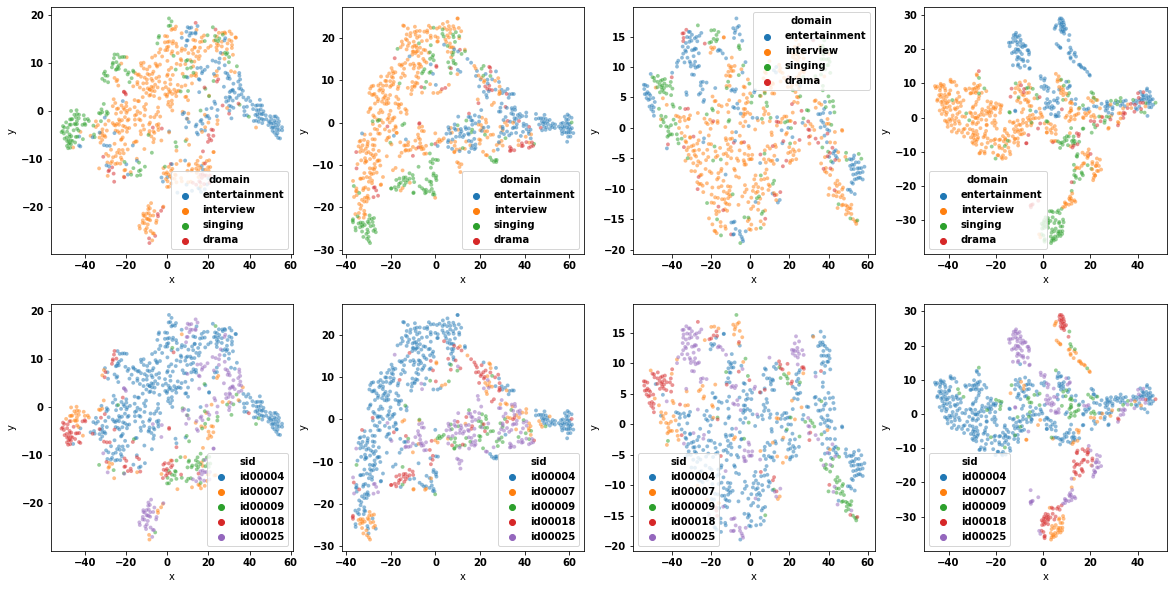

In [20]:
plt.figure(figsize=(20, 10))
layers = [1]
pca_dim=64
lamda_beta = 0.8

for i,j in enumerate(layers):
    np_feat_maps, feat_sid, feat_gid = layer_features[j]
    
    # baseline
    vis_feats(np_feat_maps.copy(), i, len(layers)+3, pca_dim=pca_dim)
    
    # whiten speaker
    vis_feats(spk_whiten(np_feat_maps.copy(), feat_sid)[0], i+1, len(layers)+3, pca_dim=pca_dim)
    
    # whiten genres
    wh_feat = spk_whiten(np_feat_maps.copy(), feat_gid)[0]
    vis_feats(wh_feat, i+2, len(layers)+3, pca_dim=pca_dim)
    
    # whiten genres -> speaker
    wh_feat = spk_whiten(np_feat_maps.copy(), feat_gid)[0]
    vis_feats(spk_whiten(wh_feat.copy(), feat_sid)[0], i+3, len(layers)+3, pca_dim=pca_dim)
    
plt.savefig('imgs/resnet/tsne_pca%d_whiten.png'%(pca_dim), bbox_inches='tight')

torch.Size([795, 640])
torch.Size([795, 640])


KeyboardInterrupt: 

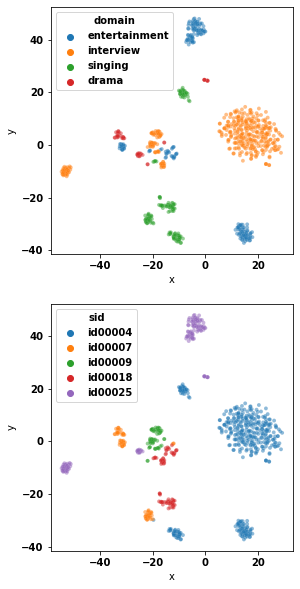

In [29]:
plt.figure(figsize=(20, 10))
layers = [7]
pca_dim=64
lamda_beta = 0.5

for i,j in enumerate(layers):
    np_feat_maps, feat_sid, feat_gid = layer_features[j]
    
    # baseline
    vis_feats(np_feat_maps.copy(), i, len(layers)+3, pca_dim=pca_dim)
    dims = [1]
    # mixstyle 
    mixed_feat = mixstyle(torch.tensor(np_feat_maps), lamda_beta, dims=dims)
    print(mixed_feat.shape)
    vis_feats(mixed_feat, i+1, len(layers)+3, pca_dim=pca_dim) 
    
    # whiten_genre -> mixtyle -> dewhiten_genre
    whitend_feats, spk_stat = spk_whiten(np_feat_maps.copy(), feat_gid)
    mixed_feat = mixstyle(torch.tensor(whitend_feats), lamda_beta, dims=dims)                          
    spk_dewhiten(mixed_feat, feat_gid, spk_stat)                     
    vis_feats(mixed_feat, i+2, len(layers)+3, pca_dim=pca_dim)
    
    # whiten_spk -> mixtyle -> dewhiten_spk
    whitend_feats, spk_stat = spk_whiten(np_feat_maps.copy(), feat_sid)
    mixed_feat = mixstyle(torch.tensor(whitend_feats), lamda_beta, dims=dims)                          
    spk_dewhiten(mixed_feat, feat_sid, spk_stat)                     
    vis_feats(mixed_feat, i+3, len(layers)+3, pca_dim=pca_dim)
    
plt.savefig('imgs/resnet/tsne_stylemix_pca{:d}_genre_spk_lam{:.2f}_layer{:d}.png'.format(pca_dim, lamda_beta, j), bbox_inches='tight')

In [ ]:
plt.figure(figsize=(20, 10))
layers = [1]
pca_dim=64
lamda_beta = 0.8

for i,j in enumerate(layers):
    np_feat_maps, feat_sid, feat_gid = layer_features[j]
    
    # baseline
    vis_feats(np_feat_maps.copy(), i, len(layers)+3, pca_dim=pca_dim)
    
    # whiten domain
    dom_wh = spk_whiten(np_feat_maps.copy(), feat_gid)[0]
    vis_feats(dom_wh, i+1, len(layers)+3, pca_dim=pca_dim)
    
    # whiten domain+spk
    spk_wh = spk_whiten(dom_wh.copy(), feat_sid)[0]
    vis_feats(spk_wh, i+2, len(layers)+3, pca_dim=pca_dim)
    
plt.savefig('imgs/resnet/tsne_stylemix_pca%d.png'%(pca_dim), bbox_inches='tight')

In [83]:
np_feat_maps, feat_sid, feat_gid = layer_features[1]

for s in sids:
    sid_mean = np_feat_maps[np.where(np.array(feat_sid) == s)].mean(axis=0, keepdims=True)
    np_feat_maps[np.where(np.array(feat_sid) == s)] = np_feat_maps[np.where(np.array(feat_sid) == s)] - sid_mean

In [93]:
sids = np.unique(feat_sid)
print(sids)
print(np.where(np.array(feat_sid) == sids[3]))

['id00004' 'id00007' 'id00009' 'id00018' 'id00025']
(array([574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586,
       587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599,
       600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
       613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625,
       626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638,
       639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651,
       652, 653, 654, 655]),)


In [96]:
sid_mean = np_feat_maps[np.where(np.array(feat_sid) == sids[0])].mean(axis=0, keepdims=True)

np_feat_maps[np.where(np.array(feat_sid) == sids[0])] = np_feat_maps[np.where(np.array(feat_sid) == sids[0])] - sid_mean

(1, 16, 151, 80)


In [102]:
a -= mean_a
b -= mean_a

print(((np_feat_maps[np.where(np.array(feat_sid) == sids[0])] - b) > 1e-4).sum())

68412760


In [16]:
domains = list(domains)
domains.sort()
domain2idx = {uid:i for i,uid in enumerate(domains)}

spks = list(spk_domain_dict.keys())
spks.sort()
spk2idx = {sid:i for i,sid in enumerate(spks)}

In [17]:
print(list(spk_domain_dict.keys())[:10])

['id00000', 'id00001', 'id00002', 'id00003', 'id00004', 'id00005', 'id00006', 'id00007', 'id00008', 'id00009']


In [18]:
numofdomains_spk = 4
numofdomains = []
for sid in spks:
    numofdomains.append(len(spk_domain_dict[sid]))
    if len(spk_domain_dict[sid]) >= numofdomains_spk:
        print(sid, end='", "')
# id00004

id00038", "id00047", "id00061", "id00070", "id00094", "id00096", "id00100", "id00108", "id00113", "id00130", "id00138", "id00152", "id00182", "id00210", "id00217", "id00222", "id00223", "id00258", "id00291", "id00304", "id00305", "id00307", "id00346", "id00351", "id00374", "id00376", "id00392", "id00394", "id00404", "id00406", "id00410", "id00412", "id00436", "id00448", "id00453", "id00458", "id00459", "id00464", "id00472", "id00476", "id00482", "id00489", "id00491", "id00498", "id00500", "id00504", "id00510", "id00522", "id00523", "id00533", "id00550", "id00555", "id00556", "id00557", "id00559", "id00601", "id00623", "id00664", "id00687", "id00693", "id00702", "id00738", "id00740", "id00747", "id00757", "id00769", "

In [107]:
all_sids = ["id00038", "id00061", "id00070", "id00094", "id00096"]
all_sid2idx = {s: i for i,s in enumerate(all_sids)}
# plt.figure(figsize=(24,6))
spk2dom2cos = {}
spk2vectors = {}
allvectors = []

for i, this_sid in enumerate(all_sids):
    # ax = plt.subplot(1,len(all_sids),i+1)
    j=0
    
    one_xvectors_dict = {}
    one_xvectors = []
    one_xvectors_dom = []
    one_xvectors_dom2cos = {}
    one_xvectors_domidx = []
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]
    
    for uid in spk2uid_dict[this_sid]:
        this_vector = kaldi_io.read_vec_flt(data_dir + '/'+ tdnn_xvector_dict[uid])
        this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 

        one_xvectors_dict[uid] = this_vector
        one_xvectors.append(this_vector)
        dom = uid.split('-')[1]
        one_xvectors_dom.append(dom)
        one_xvectors_dom2cos.setdefault(dom,[]).append(float(this_cos))
        one_xvectors_domidx.append(domain2idx[dom])
        
        allvectors.append([this_sid, this_vector, dom])

    # allvectors.extend(one_xvectors)
    one_xvectors = np.array(one_xvectors)
    spk2vectors[this_sid] = one_xvectors

In [112]:
pd_allvectors = pd.DataFrame(allvectors,columns=['sid','vector', 'domain'])
vectors = np.array([i for i in pd_allvectors['vector'].values])
spkidxs = [all_sid2idx[s] for s in list(pd_allvectors['sid'].values)]

In [113]:
vectors = PCA(n_components=64).fit_transform(vectors)

all_embeddeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(vectors)
#     one_xvectors_dom = np.array(one_xvectors_dom
pd_embeddeds = pd.DataFrame(all_embeddeds,columns=['x','y'])
pd_embeddeds.insert(2, 'sid', pd_allvectors['sid'])
pd_embeddeds.insert(3, 'domain', pd_allvectors['domain'])

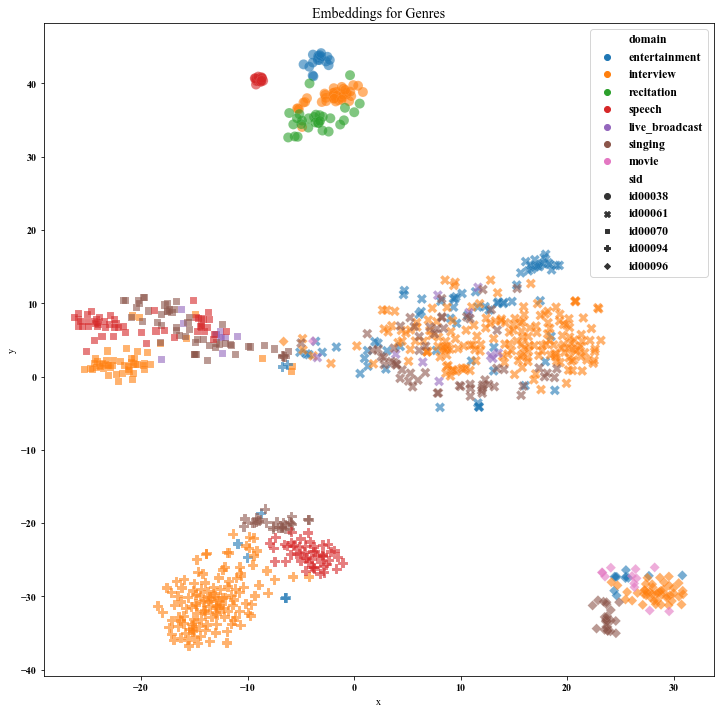

In [114]:
plt.figure(figsize=(12,12))
plt.title('Embeddings for Genres', fontsize=14)
sns.scatterplot(data=pd_embeddeds, x='x', y='y', hue='domain', style='sid', s=100, alpha=0.6, linewidth=0.1)
plt.legend(fontsize=12)

In [115]:
# 
spk1 = pd_embeddeds[pd_embeddeds['sid'] == all_sids[0]]
spk2 = pd_embeddeds[pd_embeddeds['sid'] == all_sids[1]]

n, m = len(spk1), len(spk2)
spk1_np = spk1.filter(items=['x', 'y']).values
spk2_np = spk2.filter(items=['x', 'y']).values

ot2d = OptimalTransport(spk1_np, spk2_np, lam=0.5, fit_mapping=False,)

1.0

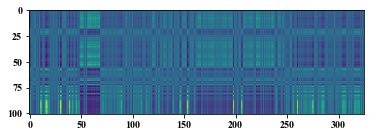

In [116]:
plt.imshow(ot2d.P)
np.sum(ot2d.P)

In [25]:
# fig, ax = plt.subplots()

# # ax.scatter(spk1_np[:,0], spk1_np[:,1], color='blue')
# # ax.scatter(spk2_np[:,0], spk2_np[:,1], color='orange')
# ax.scatter(spk1_np[:,0], spk1_np[:,1], color='blue', label='set 1')
# ax.scatter(spk2_np[:,0], spk2_np[:,1], color='orange', label='set 2')

# ax.legend(loc=0)

# for i in range(n):
#     for j in range(m):
#         if ot2d.P[i,j] > 1e-5:
#             ax.plot([spk1_np[i,0], spk2_np[j,0]], [spk1_np[i,1], spk2_np[j,1]], alpha=ot2d.P[i,j] * n, color='red')

In [ ]:
A = np.ones((2,2))*0.1
B = np.random.randn(2,2)
print(A)
print(B)

C = A.T @ B
print(C)

print(np.matmul(A.T, B)) # @ matric mul

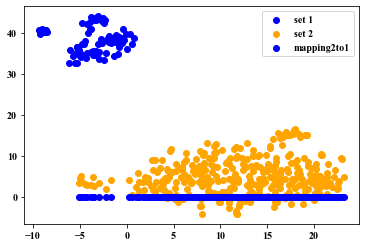

In [117]:
X, w = ot2d.interpolate(0.6)
ot2d.fit_mapping()
fig, ax = plt.subplots()

ax.scatter(spk1_np[:,0], spk1_np[:,1], color='blue', label='set 1')
ax.scatter(spk2_np[:,0], spk2_np[:,1], color='orange', label='set 2')
ax.scatter(spk2_np[:,0], ot2d.mapX2toX1(spk2_np)[:, 1], color='blue', label='mapping2to1')

# ax.scatter(X[:,0], X[:,1], color='red', label='interpolation')
ax.legend(loc=0)

In [118]:
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=spk1_np, Xt=spk2_np)
transp_Xs_emd = ot_emd.transform(Xs=spk1_np)

<AxesSubplot:xlabel='x', ylabel='y'>

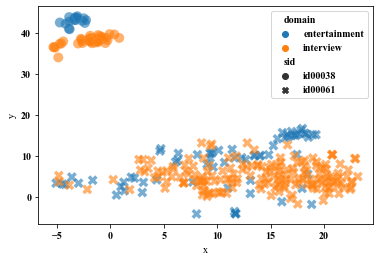

In [121]:
spk1_ds = spk1[spk1.domain.isin(['entertainment', 'interview'])]
spk2_ds = spk2[spk2.domain.isin(['entertainment', 'interview'])]

sns.scatterplot(data=spk1_ds.append(spk2_ds), x='x', y='y', hue='domain', style='sid', s=100, alpha=0.6, linewidth=0.1)

<AxesSubplot:xlabel='x', ylabel='y'>

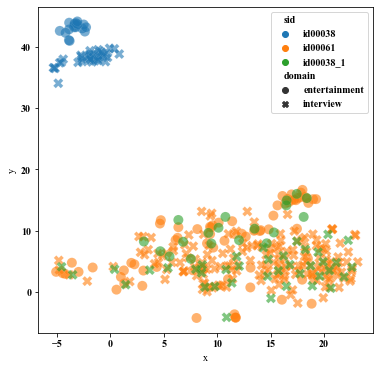

In [142]:
spk1_ds_np = spk1_ds.filter(items=['x', 'y']).values
spk2_ds_np = spk2_ds.filter(items=['x', 'y']).values

ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=spk1_ds_np, Xt=spk2_ds_np)
transp_spk1ds_emd = ot_emd.transform(Xs=spk1_ds_np)

pd_transp_spk1_ds = pd.DataFrame(transp_spk1ds_emd, columns=['x', 'y'])
pd_transp_spk1_ds.insert(2, 'sid', ['id00038_1']*len(pd_transp_spk1_ds))
pd_transp_spk1_ds.insert(3, 'domain', spk1_ds['domain'])

plt.figure(figsize=(6,6))
spk12_ds  = spk1_ds.append(spk2_ds)
spk121_ds  = spk12_ds.append(pd_transp_spk1_ds)
sns.scatterplot(data=spk121_ds, x='x', y='y', hue='sid', style='domain', s=100, alpha=0.6, linewidth=0.1)


<AxesSubplot:xlabel='x', ylabel='y'>

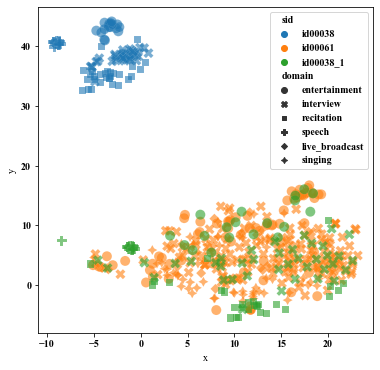

In [143]:
transp_spk1_emd = ot_emd.transform(Xs=spk1_np)

pd_transp_spk1 = pd.DataFrame(transp_spk1_emd, columns=['x', 'y'])
pd_transp_spk1.insert(2, 'sid', ['id00038_1']*len(spk1_np))
pd_transp_spk1.insert(3, 'domain', spk1['domain'])

spk12  = spk1.append(spk2)
spk121  = spk12.append(pd_transp_spk1)

plt.figure(figsize=(6,6))
sns.scatterplot(data=spk121, x='x', y='y', hue='sid', style='domain', s=100, alpha=0.6, linewidth=0.1)

<AxesSubplot:xlabel='x', ylabel='y'>

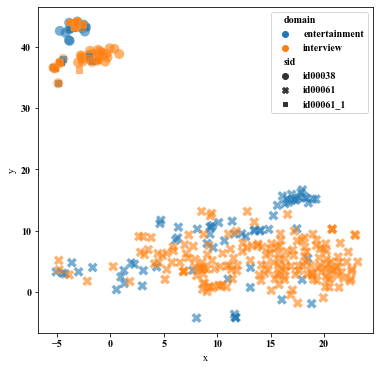

In [144]:
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=spk2_ds_np, Xt=spk1_ds_np)
transp_spk2ds_emd = ot_emd.transform(Xs=spk2_ds_np)

pd_transp_spk2_ds = pd.DataFrame(transp_spk2ds_emd, columns=['x', 'y'])
pd_transp_spk2_ds.insert(2, 'sid', ['id00061_1']*len(pd_transp_spk2_ds))
pd_transp_spk2_ds.insert(3, 'domain', spk1_ds['domain'])

plt.figure(figsize=(6,6))
spk12_ds  = spk1_ds.append(spk2_ds)
spk121_ds  = spk12_ds.append(pd_transp_spk2_ds)
sns.scatterplot(data=spk121_ds, x='x', y='y', hue='domain', style='sid', s=100, alpha=0.6, linewidth=0.1)

<AxesSubplot:xlabel='x', ylabel='y'>

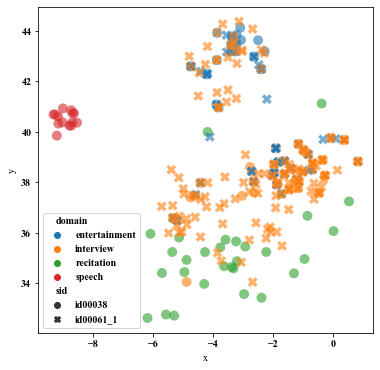

In [139]:
transp_spk2_emd = ot_emd.transform(Xs=spk2_np)

pd_transp_spk2 = pd.DataFrame(transp_spk2_emd, columns=['x', 'y'])
pd_transp_spk2.insert(2, 'sid', ['id00061_1']*len(spk2_np))
pd_transp_spk2.insert(3, 'domain', spk2['domain'])

spk12  = spk1.append(spk2)
spk121  = spk12.append(pd_transp_spk2)
spk11  = spk1.append(pd_transp_spk2)

plt.figure(figsize=(6,6))
sns.scatterplot(data=spk11, x='x', y='y', hue='domain', style='sid', s=100, alpha=0.6, linewidth=0.1)

<AxesSubplot:xlabel='x', ylabel='y'>

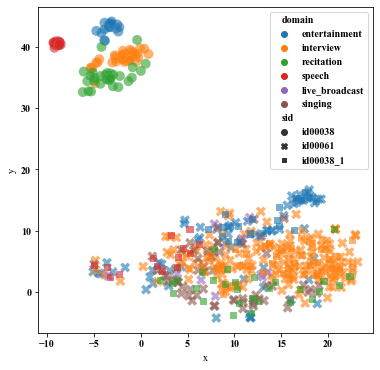

In [146]:
pd_transp_spk1 = pd.DataFrame(transp_Xs_emd, columns=['x', 'y'])
pd_transp_spk1.insert(2, 'sid', ['id00038_1']*len(pd_transp_spk1))
pd_transp_spk1.insert(3, 'domain', spk1['domain'])

spk12  = spk1.append(spk2)
spk121  = spk12.append(pd_transp_spk1)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=spk121, x='x', y='y', hue='domain', style='sid', s=100, alpha=0.6, linewidth=0.1)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(spk1_np[:,0], spk1_np[:,1], color='blue', label='spk 1')
ax.scatter(spk2_np[:,0], spk2_np[:,1], color='orange', label='spk 2')
ax.scatter(transp_Xs_emd[:,0], transp_Xs_emd[:, 1], color='green', label='map_1to2')

# ax.scatter(X[:,0], X[:,1], color='red', label='interpolation')
ax.legend(loc=0)

<AxesSubplot:>

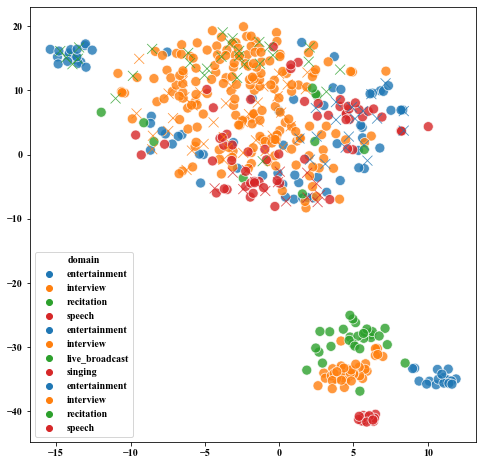

In [65]:
plt.figure(figsize=(8,8))

sns.scatterplot(x=spk1_np[:,0], y=spk1_np[:,1], hue=spk1['domain'], s=100, alpha=0.8,)
sns.scatterplot(x=spk2_np[:,0], y=spk2_np[:,1], hue=spk2['domain'], s=100, alpha=0.8,)
sns.scatterplot(x=transp_Xs_emd[:,0], y=transp_Xs_emd[:,1], hue=spk1['domain'], marker='x', s=100, alpha=0.8,)
# ax.scatter(transp_Xs_emd[:,0], transp_Xs_emd[:, 1], color='green', label='mapping1to2')

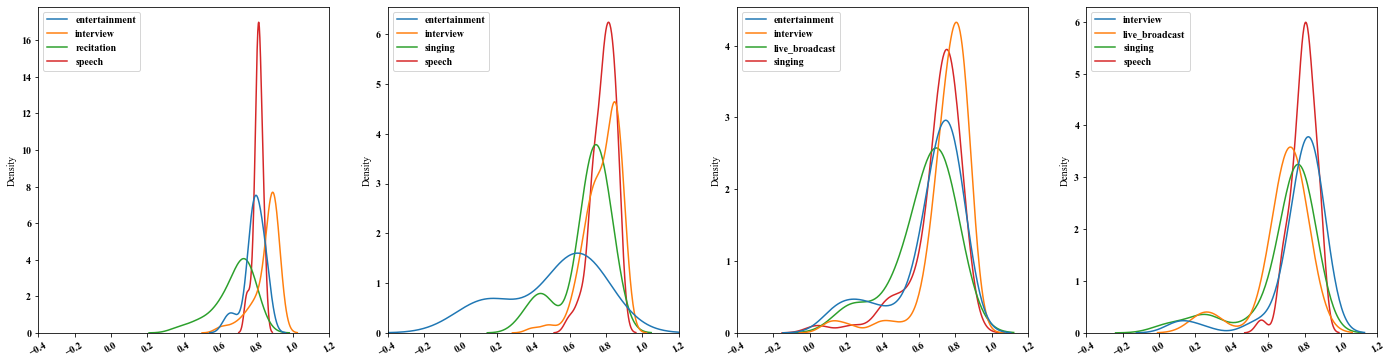

In [137]:
plt.figure(figsize=(24,6))

for i, this_sid in enumerate(all_sids):
    ax = plt.subplot(1,len(all_sids),i+1)
    j=0
    
    one_xvectors_dict = {}
    one_xvectors = []
    one_xvectors_dom = []
    one_xvectors_dom2cos = {}
    one_xvectors_domidx = []
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]
    
    for uid in spk2uid_dict[this_sid]:
        this_vector = kaldi_io.read_vec_flt(data_dir + '/'+ tdnn_xvector_dict[uid])
#             print(this_vector.shape)
        this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 

        one_xvectors_dict[uid] = this_vector
        one_xvectors.append(this_vector)
        dom = uid.split('-')[1]
        one_xvectors_dom.append(dom)
        one_xvectors_dom2cos.setdefault(dom,[]).append(float(this_cos))
        one_xvectors_domidx.append(domain2idx[dom])
    
    sns.kdeplot(data=one_xvectors_dom2cos, common_norm=False)
    # sns.displot(one_xvectors_dom2cos, kind="kde", bw_adjust=.25)
    
    ax.tick_params(axis='x', labelrotation=30)
    # ax.set_ylim(0, 20)
    ax.set_xlim(-0.4, 1.2)

In [161]:
miss_uid = []
all_cos = []
dom2cos = {}

for uid in tqdm(tdnn_xvector_dict, ncols=100):
    this_sid = uid.split('-')[0]
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]

    this_vector = kaldi_io.read_vec_flt(data_dir + '/'+tdnn_xvector_dict[uid])
    this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 
    dom = uid.split('-')[1]
    dom2cos.setdefault(dom,[]).append(float(this_cos))
    
    all_cos.append(float(this_cos))

100%|████████████████████████████████████████████████████| 111259/111259 [00:07<00:00, 13974.96it/s]


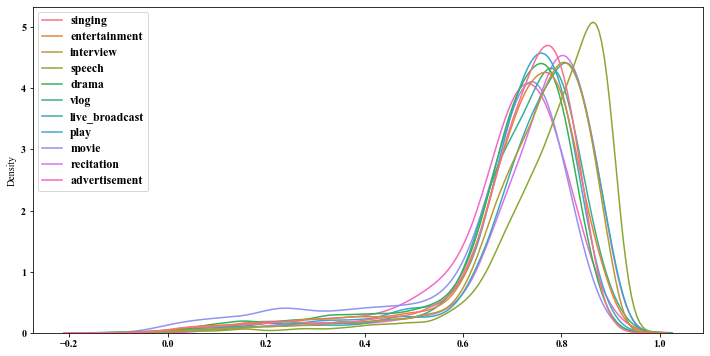

In [180]:
plt.figure(figsize=(12, 6))
ax = sns.kdeplot(data=dom2cos, common_norm=False)
_ = plt.setp(ax.get_legend().get_texts(), fontsize='12')
# lg = ax.update_params(**{'fontsize': 12})

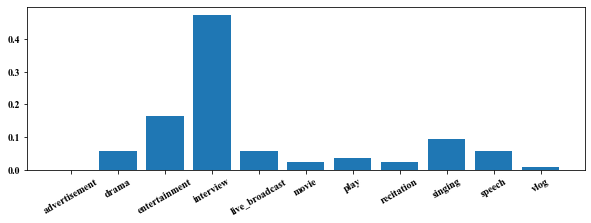

In [181]:
dom2num = []
plt.figure(figsize=(10,3))
for i,dom in enumerate(domains):
    dom2num.append(len(dom2cos[dom]))
    
plt.bar(domains, np.array(dom2num)/len(all_cos))
plt.tick_params(axis='x', labelrotation=30)

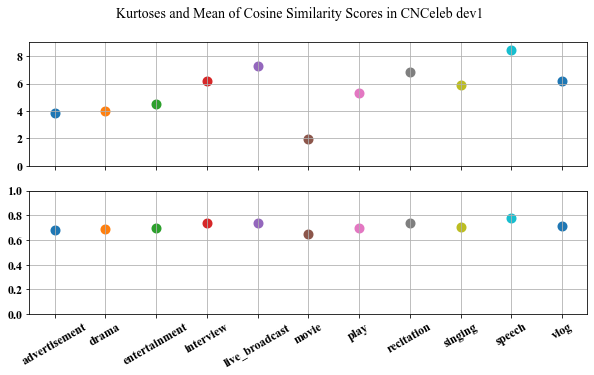

In [183]:
# x = np.arange(0, 2, 0.01)
fontsize=12
plt.figure(figsize=(10,5))
plt.suptitle("Kurtoses and Mean of Cosine Similarity Scores in CNCeleb dev1", fontsize=fontsize+2)
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
# ax3 = plt.subplot(3,1,3)

train_domain_stats = {}
for i,dom in enumerate(domains):
    dom_cos = np.array(dom2cos[dom])
    
    mean = dom_cos.mean()
    diffs = dom_cos - mean
    var = np.mean(np.power(diffs, 2.0))
    std = np.power(var, 0.5)
    z_scores = diffs / std

    kurtoses = np.mean(np.power(z_scores, 4.0)) - 3.0
#     kurtoses *= len(dom_cos)/all_cos
#     skewness = np.mean(np.power(z_scores, 3.0))
#     plt.plot(x, norm.pdf(x, mean, sd))
    ax1.scatter([dom], [kurtoses], marker='o', linewidth=4)
    ax2.scatter([dom], [mean], marker='o', linewidth=4)
#     ax3.scatter([dom], [std], marker='o', linewidth=4)
    
    train_domain_stats[dom] = [mean, std]
# plt.ylim(0,10)
# plt.xlim(0,1)
# ax1.set_xticks([])
ax1.set_xticklabels([])
# ax1.set_xticklabels([])
ax1.set_ylim(0,9)
ax2.set_ylim(0,1)
# ax2.set_xticklabels([])

for ax in [ax1, ax2]:
    ax.grid()
    ax.tick_params(axis='x', labelrotation=30)
    ax.tick_params(axis='both', labelsize=fontsize)
#     _ = ax.set_yticks(fontsize=fontsize)
#     _ = ax.set_xticks(fontsize=fontsize)
# plt.legend(list(dom2cos.keys()), fontsize=fontsize) 

# hard ==> easy
# movie adertisement drama entertainment
# vlog interview singing live_broadcast play 
# speech recitation

In [184]:
dom_center2cos = {}

for i, spk in enumerate(spk2uid_dict):
    uids = spk2uid_dict[spk]
    uids.sort()
    spk_domain_center = {}
    for uid in uids:
        dom = uid.split('-')[1]
        spk_domain_center.setdefault(dom, []).append(kaldi_io.read_vec_flt(data_dir + '/' +tdnn_xvector_dict[uid]))
    
    this_spk_center = classifier_Center[:, spk2idx[spk]]
    for dom in spk_domain_center:
        dom_center = np.array(spk_domain_center[dom])
#         print(dom_center.shape)
        dom_center = dom_center.mean(axis=0)
        this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(dom_center), dim=0)
        dom_center2cos.setdefault(dom, []).append(float(this_cos))

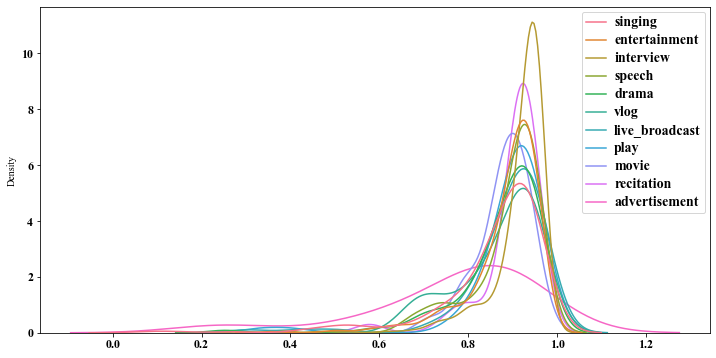

In [188]:
fontsize=12
plt.figure(figsize=(12,6))
# for i,dom in enumerate(domains):
#     ax = plt.subplot(len(dom2cos),1,i+1)
    # dom_cos = np.array(dom_center2cos[dom])
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
    # _ = plt.hist(dom_cos, alpha=0.5, bins=50, density=True, histtype='step')

ax = sns.kdeplot(data=dom_center2cos, common_norm=False)
# plt.legend(domains, fontsize=fontsize) 
_ = plt.setp(ax.get_legend().get_texts(), fontsize=fontsize+2)
_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

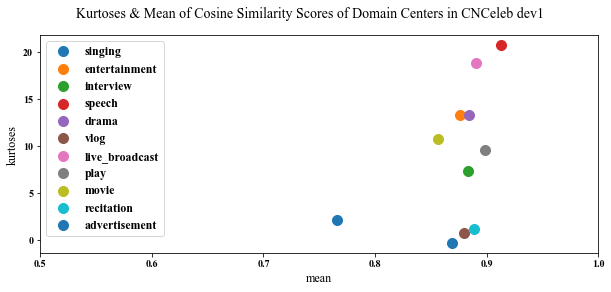

In [198]:
plt.figure(figsize=(10,4))
plt.suptitle("Kurtoses & Mean of Cosine Similarity Scores of Domain Centers in CNCeleb dev1", fontsize=fontsize+2)
# ax1 = plt.subplot(2,1,1)
# ax2 = plt.subplot(2,1,2)

domain_kurtoses = []

for i,dom in enumerate(domains):
    dom_cos = np.array(dom_center2cos[dom])
    
    mean = dom_cos.mean()
    diffs = dom_cos - mean
    var = np.mean(np.power(diffs, 2.0))
    std = np.power(var, 0.5)
    z_scores = diffs / std
    
    kurtoses = np.mean(np.power(z_scores, 4.0)) - 3.0
    domain_kurtoses.append(kurtoses)
    plt.scatter([mean], [kurtoses], marker='o', s=100)
    # ax1.scatter([dom], [kurtoses], marker='o', linewidth=4)
    # ax2.scatter([dom], [mean], marker='o', linewidth=4)
    
# ax1.set_xticklabels([])
# ax2.set_ylim(0,1)
# for ax in [ax1, ax2]:
#     ax.grid()
    
#     ax.tick_params(axis='x', labelrotation=30)
#     ax.tick_params(axis='both', labelsize=fontsize)
plt.xlim(0.5, 1)
plt.ylabel('kurtoses', fontsize=fontsize)
plt.xlabel('mean', fontsize=fontsize)
plt.legend(list(dom2cos.keys()), fontsize=fontsize) 
# Hard ==> Easy

# movie adertisement drama entertainment
# vlog interview singing live_broadcast play 
# speech recitation

In [199]:
spk_center2cos = []

for i, spk in enumerate(spks):
    uids = spk2uid_dict[spk]
    spk_center = []
    for uid in uids:
        spk_center.append(kaldi_io.read_vec_flt(data_dir + '/' +tdnn_xvector_dict[uid]))
    
    this_spk_center = classifier_Center[:, spk2idx[spk]]
    center = np.array(spk_center).mean(axis=0)
    this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(center), dim=0)
    if this_cos < 0.7:
        print(spk, ' ', end='')
        
    spk_center2cos.append(float(this_cos))

id00098  id00202  id00277  id00347  id00602  id00753  id00798  

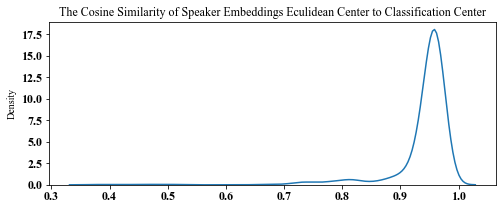

In [214]:
fontsize=12
plt.figure(figsize=(8,3))
center2cos = np.array(spk_center2cos)
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
# plt.hist(center2cos, alpha=0.5, bins=100, density=True, histtype='step')
ax = sns.kdeplot(data=center2cos, common_norm=False)

# plt.legend(domains, fontsize=fontsize) 

_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)
_ = plt.title('The Cosine Similarity of Speaker Embeddings Eculidean Center to Classification Center')

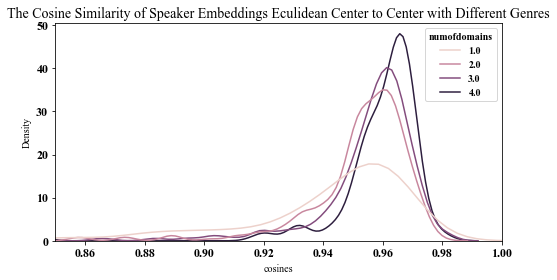

In [243]:
fontsize=12
plt.figure(figsize=(8, 4))
_ = plt.title('The Cosine Similarity of Speaker Embeddings Eculidean Center to Center with Different Genres', fontsize=fontsize+2)
center2cos = np.array(spk_center2cos)
pd_center2cos = pd.DataFrame(center2cos, columns=['cosines'])
pd_center2cos.insert(1, 'numofdomains', numofdomains)
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
# plt.hist(center2cos, alpha=0.5, bins=800, density=True, histtype='step')
filtered  = pd_center2cos.where(pd_center2cos['numofdomains']<5)
ax = sns.kdeplot(data=filtered, x='cosines', hue='numofdomains', common_norm=False, bw_adjust=0.3)

# plt.scatter(numofdomains, center2cos, alpha=0.5)
# plt.legend(domains, fontsize=fontsize) 
plt.xlim(0.85, 1)
_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

# 1->4种场景，场景越丰富，说话人向量的欧几里得中心离分类的中心越集中
# 多于4种场景的说话人没有考虑，因为样本太少

In [231]:
pd_center2cos['numofdomains'].value_counts()

2    300
1    230
3    204
4     58
5      6
6      1
7      1
Name: numofdomains, dtype: int64

1 :  230
2 :  300
3 :  204
4 :  58
5 :  6
6 :  1
7 :  1


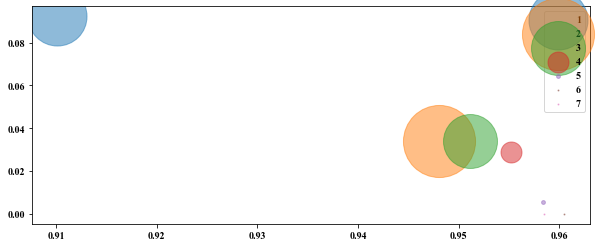

In [33]:
numofdomian2cos = {}
plt.figure(figsize=(10,4))

for n,c in zip(numofdomains, center2cos):
    numofdomian2cos.setdefault(n, []).append(c)

for i in range(1,8):
    mean = np.mean(numofdomian2cos[i])
    std = np.std(numofdomian2cos[i])
    print(i,': ', len(numofdomian2cos[i]))
    plt.scatter(mean, std, len(numofdomian2cos[i])**1.5, alpha=0.5)
    
plt.legend([str(i) for i in range(1,8)])

In [34]:
tdnn_test_score_f = 'Data/xvector/TDNN_v5/cnceleb/klfb_egs_baseline/arcsoft/Mean_STAP_em512_wd5e4_var/test/epoch_50/scores'
tdnn_test_scores = []

with open(os.path.join(data_dir, tdnn_test_score_f), 'r') as f:
    for l in f.readlines():
        s,l = l.split()
        tdnn_test_scores.append((float(s), l))
        
test_domain = []
with open(os.path.join(lstm_dir, 'cnceleb/test/trials'), 'r') as f:
    for l in f.readlines():
        _, test_uid, _ = l.split()
        test_domain.append(test_uid.split('-')[1])

In [35]:
tdnn_test_scores[:1]

[(0.17569156, 'True')]

In [36]:
from Eval.eval_metrics import evaluate_kaldi_eer, evaluate_kaldi_mindcf

In [ ]:
scores = []
labels = []

for (s,l),d in zip(tdnn_test_scores, test_domain):
    s = (s-train_domain_stats[d][0]) / train_domain_stats[d][1]
    scores.append(s)
    if l == 'True':
        labels.append(True)
    else:
        labels.append(False)

eer, eer_threshold, accuracy = evaluate_kaldi_eer(scores, labels, cos=True, re_thre=True)
mindcf_01, mindcf_001 = evaluate_kaldi_mindcf(scores, labels)

In [139]:
domain_score = open('domain_scores', 'w')
with open(os.path.join(lstm_dir, 'cnceleb/test/trials'), 'r') as f:
    i = 0
    for l in f.readlines():
        enroll_uid, test_uid, _ = l.split()
        domain_score.write(enroll_uid + ' ' + test_uid + ' ' + str(scores[i]) +'\n')
        i += 1
#         test_domain.append(test_uid.split('-')[1])

In [ ]:
print(eer)
print(mindcf_01, ' ', mindcf_001)

In [137]:
print(len(labels))

3604800


In [37]:
# miss_uid = []
all_othercos = []
other_dom2cos = {}
other_spks = np.arange(800)

for uid in tqdm(tdnn_xvector_dict, ncols=100):
    this_sid = uid.split('-')[0]
    
    other_spks_idx = np.delete(other_spks, [spk2idx[this_sid]])
    other_spk_center = classifier_Center[:, other_spks_idx]

    this_vector = kaldi_io.read_vec_flt(data_dir + '/'+tdnn_xvector_dict[uid])
    this_cos = torch.nn.functional.cosine_similarity(other_spk_center, torch.tensor(this_vector).reshape(-1, 1).repeat(1,799), dim=0) 
    
    dom = uid.split('-')[1]
    other_dom2cos.setdefault(dom,[]).extend(this_cos.tolist())
    
    all_othercos.extend(this_cos.tolist())

100%|███████████████████████████████████████████████████████| 91824/91824 [00:48<00:00, 1906.92it/s]


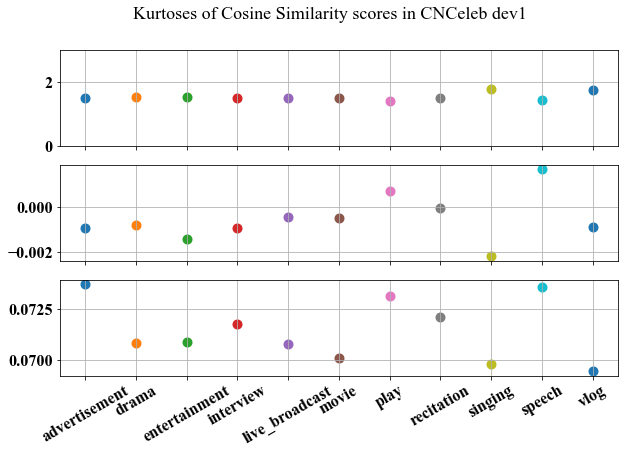

In [38]:
# x = np.arange(0, 2, 0.01)
plt.figure(figsize=(10,6))
plt.suptitle("Kurtoses of Cosine Similarity scores in CNCeleb dev1", fontsize=fontsize+2)
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

other_train_domain_stats = {}
for i,dom in enumerate(domains):
    dom_cos = np.array(other_dom2cos[dom])
    
    mean = dom_cos.mean()
    diffs = dom_cos - mean
    var = np.mean(np.power(diffs, 2.0))
    std = np.power(var, 0.5)
    z_scores = diffs / std

    kurtoses = np.mean(np.power(z_scores, 4.0)) - 3.0
    
    ax1.scatter([dom], [kurtoses], marker='o', linewidth=4)
    ax2.scatter([dom], [mean], marker='o', linewidth=4)
    ax3.scatter([dom], [std], marker='o', linewidth=4)
    
    other_train_domain_stats[dom] = [mean, std]

ax1.set_xticklabels([])
ax1.set_ylim(0,3)
ax2.set_xticklabels([])

for ax in [ax1, ax2, ax3]:
    ax.grid()
    
    ax.tick_params(axis='x', labelrotation=30)
    ax.tick_params(axis='both', labelsize=fontsize)


In [143]:
scores = []
labels = []

for (s,l),d in zip(tdnn_test_scores, test_domain):
    s = (s-other_train_domain_stats[d][0]) / other_train_domain_stats[d][1]
    scores.append(s)
    if l == 'True':
        labels.append(True)
    else:
        labels.append(False)

domain_score = open('other_domain_scores', 'w')
with open(os.path.join(lstm_dir, 'cnceleb/test/trials'), 'r') as f:
    i = 0
    for l in f.readlines():
        enroll_uid, test_uid, _ = l.split()
        domain_score.write(enroll_uid + ' ' + test_uid + ' ' + str(scores[i]) +'\n')
        i += 1

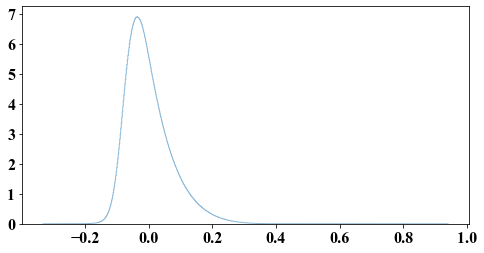

In [144]:
fontsize=16

plt.figure(figsize=(8, 3))

center2cos = np.array(all_othercos)

plt.hist(center2cos, alpha=0.5, bins=800, density=True, histtype='step')
_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

In [2]:
import torch

In [24]:
half_data = 12
label = torch.randint(0, 20, (half_data*2,))

idx=20

index_list = {}
for i in range(20):
    for j in range(i+1, 20):
        index_list['%d_%d'%(i,j)] = idx
        idx += 1

In [25]:
half_label = label[half_data:]

rand_idx = torch.randperm(half_data)
rand_label = half_label.clone()[rand_idx]

In [27]:
len(index_list)

190

In [13]:
rand_label

tensor([15, 10,  9,  4, 10,  7,  9,  6,  6, 13, 10,  5])

In [19]:
relabel = []

for x,y in zip(half_label, rand_label):
    if x==y:
        relabel.append(int(x))
    elif x<y:
        relabel.append(index_list['%d_%d'%(x,y)])
    else :
        relabel.append(index_list['%d_%d'%(y,x)])
        
relabel = torch.LongTensor(relabel)

In [20]:
relabel

tensor([170,  10, 141, 100, 178, 147,   9,   6,  96, 132,  10,   5])